# Setup

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1eCJz8mommzUbqhIvGm0GHx2AlR_Iw01V&authuser=0&export=download --folder
!unzip dataset.zip
!rm -rf dataset.zip

/bin/bash: --folder: command not found
Downloading...
From: https://drive.google.com/uc?id=1eCJz8mommzUbqhIvGm0GHx2AlR_Iw01V
To: /content/dataset.zip
100% 242M/242M [00:05<00:00, 44.6MB/s]
Archive:  dataset.zip
   creating: dataset/
   creating: dataset/COVID/
  inflating: dataset/COVID/Covid (937).png  
  inflating: dataset/COVID/Covid (936).png  
  inflating: dataset/COVID/Covid (922).png  
  inflating: dataset/COVID/Covid (952).png  
  inflating: dataset/COVID/Covid (997).png  
  inflating: dataset/COVID/Covid (934).png  
  inflating: dataset/COVID/Covid (956).png  
  inflating: dataset/COVID/Covid (975).png  
  inflating: dataset/COVID/Covid (978).png  
  inflating: dataset/COVID/Covid (875).png  
  inflating: dataset/COVID/Covid (901).png  
  inflating: dataset/COVID/Covid (99).png  
  inflating: dataset/COVID/Covid (912).png  
  inflating: dataset/COVID/Covid (867).png  
  inflating: dataset/COVID/Covid (900).png  
  inflating: dataset/COVID/Covid (94).png  
  inflating: dataset/

## Functions and Constants

In [ ]:
RANDON_STATE = 42
ITERATIONS_OF_DATA_AUGMENTATION = 100

covid_class = ['non-COVID', 'COVID']
data_dir = 'dataset/'
train_dir = os.path.join(data_dir)
IMAGE_SIZE = 64

PATH_FOR_IMG_AUGMENTATION_COVID = 'aug/covid_class/'
PATH_FOR_IMG_AUGMENTATION_NON_COVID = 'aug/non_covid_class/'

COVID_DATA_PATH = 'dataset/COVID'
NON_COVID_DATA_PATH = 'dataset/non-COVID'

In [ ]:
def create_data_frame():
    train_data = []
    for defects_id, sp in enumerate(covid_class):
        for file in os.listdir(os.path.join(train_dir, sp)):
            train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
    return pd.DataFrame(train_data, columns=[
        'file', 'id_class', 'class'])

In [ ]:
def random_data_frame(data):
    data = data.sample(frac=1, random_state=RANDON_STATE)
    data.index = np.arange(len(data))
    return data

In [ ]:
def read_image(filepath, in_rgb):  # Loading a color image is the default flag
    return cv2.imread(os.path.join(data_dir, filepath), in_rgb)

In [ ]:
def resize_image(image, image_size):  # Resize image to target size
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
def load_images(data, in_rgb):
    grayscale_shape = (data.shape[0], IMAGE_SIZE, IMAGE_SIZE)
    color_shape = (data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)

    X_train = None

    if (in_rgb == 1):
      X_train = np.zeros(color_shape)
    else:
      X_train = np.zeros(grayscale_shape)

    print(X_train.shape)

    for i, file in tqdm(enumerate(data['file'].values)):
        image = read_image(file, in_rgb)
        if image is not None:
            X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
    print("Total de imagens carregadas: " + str(len(X_train)))
    return X_train

In [ ]:
def image_data_gen():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0,
        height_shift_range=0,
        zoom_range=0.1,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest',
    )

In [ ]:
def create_augmentation_for_images(from_path, save_to_path, n_iter):
  img_gen = image_data_gen()
  aug_images = img_gen.flow_from_directory(
      from_path,
      target_size=(IMAGE_SIZE, IMAGE_SIZE),
      save_to_dir=save_to_path,
      class_mode = None,
      save_prefix='generated_',
      batch_size=100,
      color_mode="rgb",
      subset=None,
  )

  for x in range(0, n_iter):
    aug_images.next()

In [ ]:
def get_reshape_from_3d_to_1d(data):
  return (data.shape[0], IMAGE_SIZE * IMAGE_SIZE * 3)

In [ ]:
def get_reshape_from_2d_to_1d(data):
  return (data.shape[0], data.shape[1] * data.shape[2])

In [ ]:
def plot_metrics(y_test, y_pred, model):
  # Metrics
  print(classification_report(y_test, y_pred, target_names=['non-covid', 'covid']))

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()
  plt.show()

  # ROC Curve
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  plt.plot(false_positive_rate, true_positive_rate, label='Best Model ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()



# GrayScale vs RGB

> Section running models with original dataset comparing images imported in Grayscale against RGB.



### Grayscale Model

In [ ]:
data = create_data_frame()
data = random_data_frame(data)
images = load_images(data, in_rgb = 0)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images, y_targets, test_size=0.2, stratify=data['id_class'])

X_train = X_train.reshape(get_reshape_from_2d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_2d_to_1d(X_test))

(2481, 64, 64)


2481it [00:12, 203.47it/s]

Total de imagens carregadas: 2481


In [ ]:
model = make_pipeline(SVC())

In [ ]:
model.fit(X_train, y_train)

Pipeline(steps=[('svc', SVC())])

In [ ]:
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

   non-covid       0.86      0.92      0.89       246
       covid       0.92      0.86      0.89       251

    accuracy                           0.89       497
   macro avg       0.89      0.89      0.89       497
weighted avg       0.89      0.89      0.89       497



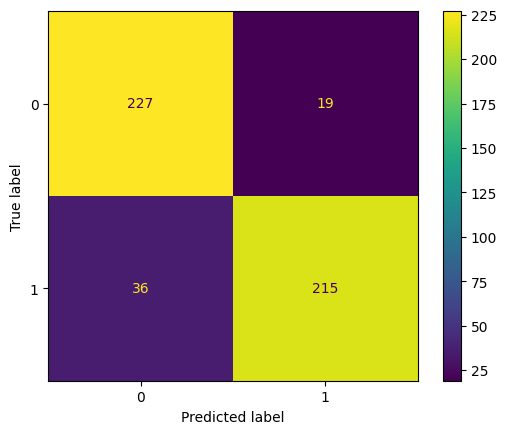

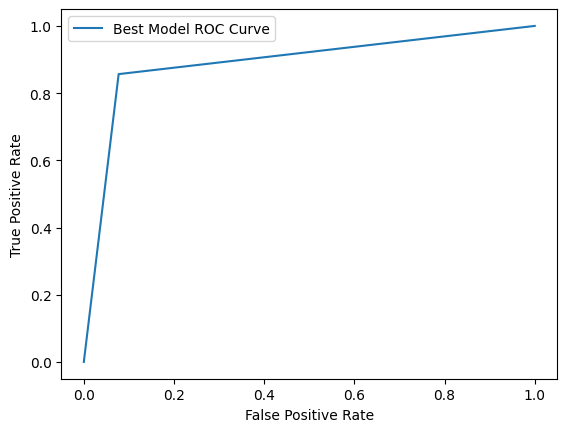

In [ ]:
plot_metrics(y_test, y_pred, model)

### RGB Model

In [ ]:
data = create_data_frame()
data = random_data_frame(data)
images_in_rgb = load_images(data, in_rgb=1)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images_in_rgb,
    y_targets,
    test_size=0.2,
    stratify=data['id_class'],
    random_state=RANDON_STATE
)


(2481, 64, 64, 3)


2481it [00:08, 292.92it/s]


Total de imagens carregadas: 2481


In [ ]:
X_train = X_train.reshape(get_reshape_from_3d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_3d_to_1d(X_test))


model = make_pipeline(SVC())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8913480885311871

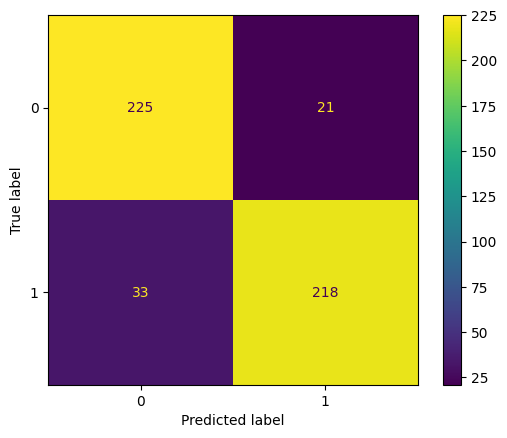

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

### Results of GrayScale vs RGB


> GrayScale model had a slightly improvement over RGB



# Optimizing

In [ ]:
data = create_data_frame()
data = random_data_frame(data)
images = load_images(data, in_rgb = 0)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images, y_targets, test_size=0.2, stratify=data['id_class'])

X_train = X_train.reshape(get_reshape_from_2d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_2d_to_1d(X_test))

(2481, 64, 64)


2481it [00:07, 326.21it/s]


Total de imagens carregadas: 2481


## Normalization
> Using StandardScaler to normalize the pixels data



In [ ]:
model = make_pipeline(StandardScaler(), SVC())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

   non-covid       0.92      0.93      0.93       246
       covid       0.94      0.92      0.93       251

    accuracy                           0.93       497
   macro avg       0.93      0.93      0.93       497
weighted avg       0.93      0.93      0.93       497



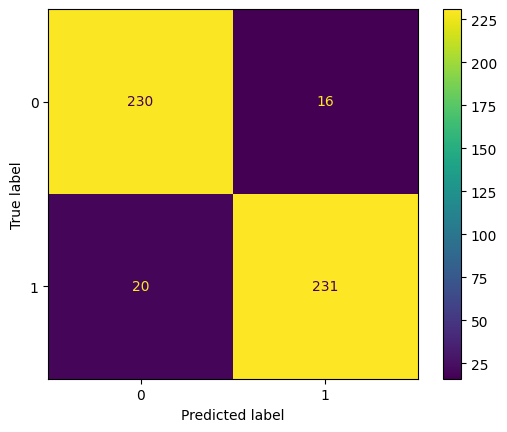

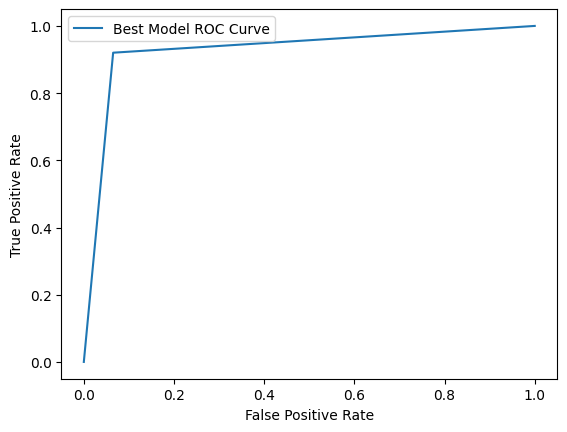

In [ ]:
plot_metrics(y_test, y_pred, model)

## Feature Selection
> Using SelectPercentile to reduce the features from the dataset



In [ ]:
model = make_pipeline(SelectPercentile(chi2, percentile=80), StandardScaler(), SVC())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

   non-covid       0.92      0.92      0.92       246
       covid       0.92      0.92      0.92       251

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497



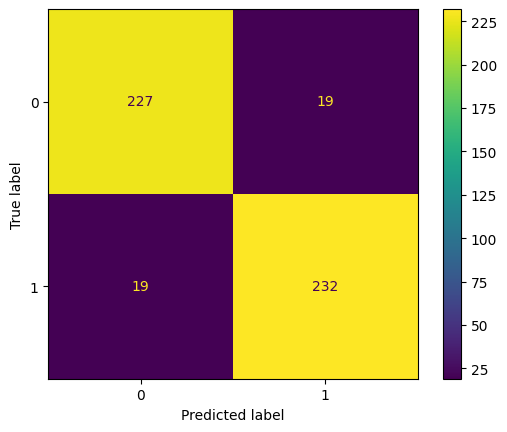

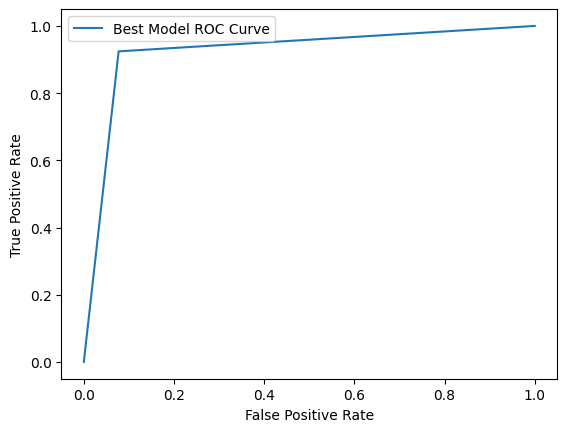

In [ ]:
plot_metrics(y_test, y_pred, model)

## Finding Best H-Params
> Using GridSearch to find the best setup for the model



In [ ]:
model_pipe = Pipeline(
    steps=[
      ('features', SelectPercentile()),
      ('scaler', StandardScaler()),
      ('svm', SVC())
    ])
parameters = {
    "features__score_func": [chi2, f_classif],
    "features__percentile": [50, 80, 100],
    "svm__kernel": ['poly', 'sigmoid', 'rbf'],
    "svm__C": [1., 0.3, 10],
    "svm__gamma": ['auto', 'scale'],
}
grid_pipeline = GridSearchCV(model_pipe, parameters, cv=5)
grid_pipeline.fit(X_train, y_train)

y_pred = grid_pipeline.predict(X_test)

In [ ]:
grid_pipeline.best_params_

{'features__percentile': 80,
 'features__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>,
 'svm__C': 1.0,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf'}

In [ ]:
print("GridSearch Results")
print()
means = grid_pipeline.cv_results_['mean_test_score']
stds = grid_pipeline.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_pipeline.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

{'mean_fit_time': array([ 2.35696816,  2.13996024,  1.99398522,  2.39418931,  1.90590267,
        1.95178504,  2.33424993,  1.63878045,  1.77173629,  2.13402863,
        1.61287827,  1.77384853,  2.18613563,  1.68145485,  1.86395693,
        2.13664899,  1.60656095,  1.91852427,  2.1863739 ,  2.19732084,
        2.10793214,  2.24959683,  2.15637703,  2.11972289,  2.05710316,
        1.36222978,  1.65146637,  2.06089015,  1.31177015,  1.70053406,
        2.10560408,  1.32104921,  1.72422185,  2.06561093,  1.24696522,
        1.69324946,  2.12978249,  1.53108926,  1.81977377,  2.28884382,
        1.56947546,  1.79131494,  2.2526526 ,  2.07710547,  1.98702269,
        2.21898131,  2.02720222,  1.98640933, 26.07964983, 25.00526133,
       27.05615983, 26.74158201, 25.15833874, 25.71795144, 26.15830355,
       25.29038363, 25.80698647, 26.34768353, 25.80529089, 26.23030224,
       26.58354068, 25.68146119, 26.06837168, 26.32723737, 25.92573862,
       25.86363082, 26.39638391, 25.95909333, 

In [ ]:
pd.DataFrame(grid_pipeline.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__percentile,param_features__score_func,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.356968,0.181162,0.432759,0.061141,50,<function chi2 at 0x7fbc133c2830>,1.0,auto,poly,"{'features__percentile': 50, 'features__score_...",0.831234,0.775819,0.803526,0.720403,0.787879,0.783772,0.036711,103
1,2.139960,0.306026,0.235569,0.055715,50,<function chi2 at 0x7fbc133c2830>,1.0,auto,sigmoid,"{'features__percentile': 50, 'features__score_...",0.732997,0.680101,0.687657,0.602015,0.694444,0.679443,0.042793,187
2,1.993985,0.098138,0.592587,0.043435,50,<function chi2 at 0x7fbc133c2830>,1.0,auto,rbf,"{'features__percentile': 50, 'features__score_...",0.921914,0.884131,0.879093,0.848866,0.901515,0.887104,0.024309,29
3,2.394189,0.113167,0.463917,0.056519,50,<function chi2 at 0x7fbc133c2830>,1.0,scale,poly,"{'features__percentile': 50, 'features__score_...",0.831234,0.775819,0.803526,0.720403,0.787879,0.783772,0.036711,103
4,1.905903,0.227727,0.209705,0.025418,50,<function chi2 at 0x7fbc133c2830>,1.0,scale,sigmoid,"{'features__percentile': 50, 'features__score_...",0.732997,0.680101,0.687657,0.602015,0.694444,0.679443,0.042793,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,29.493939,0.440707,1.173950,0.056874,100,<function mutual_info_classif at 0x7fbc12a211b0>,0.1,auto,sigmoid,"{'features__percentile': 100, 'features__score...",0.823678,0.758186,0.758186,0.783375,0.772727,0.779231,0.024169,105
212,29.858620,0.321385,1.688276,0.034637,100,<function mutual_info_classif at 0x7fbc12a211b0>,0.1,auto,rbf,"{'features__percentile': 100, 'features__score...",0.843829,0.770781,0.778338,0.783375,0.808081,0.796881,0.026597,87
213,29.804463,0.291932,1.359740,0.074463,100,<function mutual_info_classif at 0x7fbc12a211b0>,0.1,scale,poly,"{'features__percentile': 100, 'features__score...",0.682620,0.612091,0.637280,0.614610,0.628788,0.635077,0.025503,201
214,28.828307,0.395081,1.065397,0.069138,100,<function mutual_info_classif at 0x7fbc12a211b0>,0.1,scale,sigmoid,"{'features__percentile': 100, 'features__score...",0.823678,0.758186,0.758186,0.783375,0.772727,0.779231,0.024169,105


              precision    recall  f1-score   support

   non-covid       0.92      0.92      0.92       246
       covid       0.92      0.92      0.92       251

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497



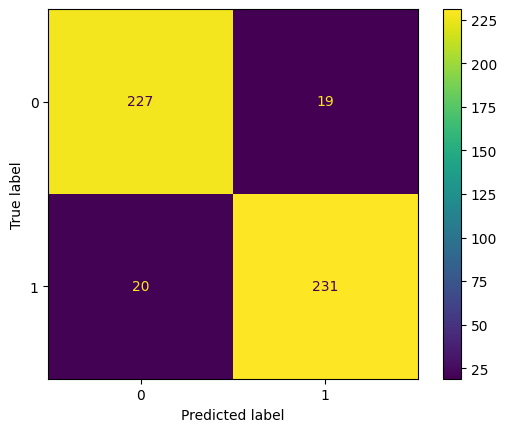

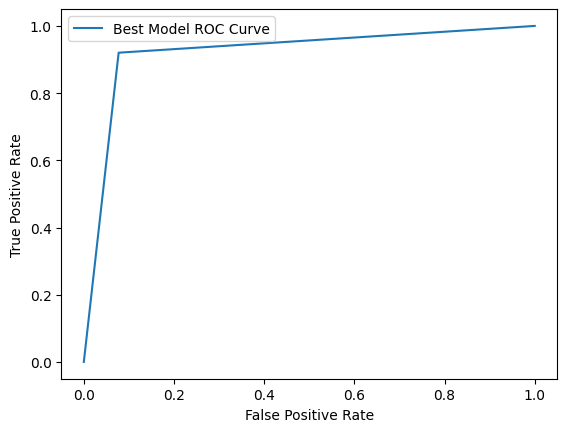

In [ ]:
plot_metrics(y_test, y_pred, model)

## Data Augmentation


> Oversampling the database and run the best model found with GridSearch



In [ ]:
!cd dataset/COVID/ && rm generated_*.png
!cd dataset/non-COVID/ && rm generated_*.png

!rm -rf aug/

!mkdir -p aug/covid_class/
!cp -R dataset/COVID aug/covid_class/

!mkdir -p aug/non_covid_class/
!cp -R dataset/non-COVID aug/non_covid_class/

create_augmentation_for_images(
    from_path=PATH_FOR_IMG_AUGMENTATION_COVID,
    save_to_path=COVID_DATA_PATH,
    n_iter=ITERATIONS_OF_DATA_AUGMENTATION
)
create_augmentation_for_images(
    from_path=PATH_FOR_IMG_AUGMENTATION_NON_COVID,
    save_to_path=NON_COVID_DATA_PATH,
    n_iter=ITERATIONS_OF_DATA_AUGMENTATION
)

data = create_data_frame()
data = random_data_frame(data)
images = load_images(data, in_rgb = 0)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images, y_targets, test_size=0.2, stratify=data['id_class'])

X_train = X_train.reshape(get_reshape_from_2d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_2d_to_1d(X_test))

rm: cannot remove 'generated_*.png': No such file or directory
rm: cannot remove 'generated_*.png': No such file or directory
Found 1252 images belonging to 1 classes.
Found 1229 images belonging to 1 classes.
(21648, 64, 64)


21648it [00:12, 1787.69it/s]


Total de imagens carregadas: 21648


In [ ]:
grid_pipeline.best_estimator_.fit(X_train, y_train)
y_pred = grid_pipeline.best_estimator_.predict(X_test)

              precision    recall  f1-score   support

   non-covid       0.92      0.96      0.94      2147
       covid       0.96      0.92      0.94      2183

    accuracy                           0.94      4330
   macro avg       0.94      0.94      0.94      4330
weighted avg       0.94      0.94      0.94      4330



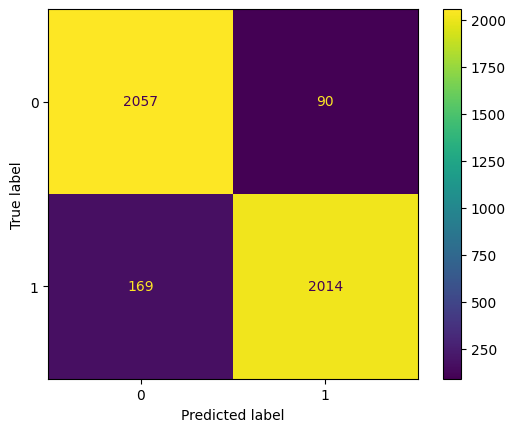

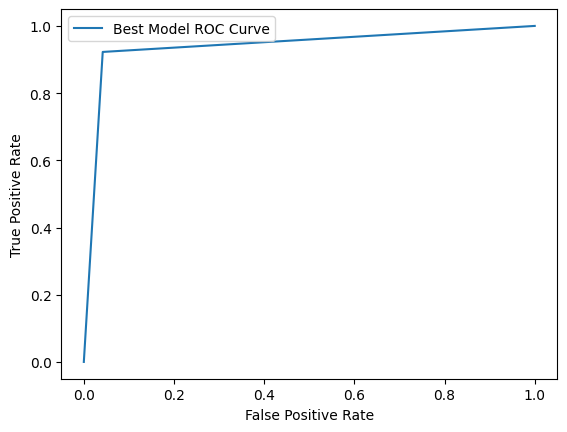

In [ ]:
plot_metrics(y_test, y_pred, model)

## Final Model



In [ ]:
!cd dataset/COVID/ && rm generated_*.png
!cd dataset/non-COVID/ && rm generated_*.png

!rm -rf aug/

!mkdir -p aug/covid_class/
!cp -R dataset/COVID aug/covid_class/

!mkdir -p aug/non_covid_class/
!cp -R dataset/non-COVID aug/non_covid_class/

create_augmentation_for_images(
    from_path=PATH_FOR_IMG_AUGMENTATION_COVID,
    save_to_path=COVID_DATA_PATH,
    n_iter=ITERATIONS_OF_DATA_AUGMENTATION
)
create_augmentation_for_images(
    from_path=PATH_FOR_IMG_AUGMENTATION_NON_COVID,
    save_to_path=NON_COVID_DATA_PATH,
    n_iter=ITERATIONS_OF_DATA_AUGMENTATION
)

data = create_data_frame()
data = random_data_frame(data)
images = load_images(data, in_rgb = 0)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images, y_targets, test_size=0.2, stratify=data['id_class'])

X_train = X_train.reshape(get_reshape_from_2d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_2d_to_1d(X_test))

Found 1252 images belonging to 1 classes.
Found 1229 images belonging to 1 classes.
(40695, 64, 64)


40695it [00:24, 1648.96it/s]


Total de imagens carregadas: 40695


In [ ]:
model = make_pipeline(StandardScaler(), SVC())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_metrics(y_test, y_pred, model)